# Amazon Reviews - Sentiment Model Experimentation

### Imports

In [ ]:
!conda install -y -c conda-forge fastparquet scikit-learn arrow-cpp parquet-cpp pyarrow numpy

In [164]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import pandas as pd
import subprocess
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import gzip
from io import BytesIO
import zipfile
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
import nltk
from fastparquet import write
from fastparquet import ParquetFile
import s3fs
import pyarrow.parquet as pq
import pickle
import glob
import ast 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from collections import OrderedDict

### Configs and Global Vars

In [ ]:
configs = {
    'aws_region' :  'us-east-1',
    'bucket_name': 'demos-amazon-reviews',
    'prefix' : 'preprocessed_reviews_csvs', #only use this if you want to have your files in a folder 
    'index_key' : 'review_date_str',
    'file_extension' :'.csv'
   
}

global_vars = {}

### Environment Setup

Setting up the environment involves ensuring all the corret session and IAM roles are configured. We also need to ensure the correct region and bucket is made available.

In [ ]:
def setup_env(configs, global_vars):
    
    sess = sagemaker.Session()
    
    role = get_execution_role()

    AWS_REGION = configs['aws_region']
    s3 = boto3.resource('s3')

    s3_bucket = s3.Bucket(configs['bucket_name'])

    if s3_bucket.creation_date == None:
    # create S3 bucket because it does not exist yet
        print('Creating S3 bucket {}.'.format(bucket))
        resp = s3.create_bucket(
            ACL='private',
            Bucket=bucket
        )
    else:
        print('Bucket already exists')
        
    global_vars['role'] = role
    global_vars['sess'] = sess
    global_vars['s3'] = s3
    global_vars['s3_bucket'] = s3_bucket
    
    return global_vars

global_vars = setup_env(configs, global_vars)

### Create Data Manifest

At this step, we need to create an index of all the files we're going to be using for this experiment and model building. Now, we don't want to download all of the data at once, or we're going to cause a lot of I/O activity for your Notebook Instance. 

What we're going to do is first create a path index to where the files live on S3. From there, we can do some sampling to get to see what the data looks like, do some basic sampling stats on the data, to get a better handle on how we should build a model, and then move to using all the data to build a robust model!

In [ ]:
def create_dataset_manifest(configs, global_vars):
    
    interval_printer_idx = 100
    idx = 0
    1
    conn = global_vars['s3_bucket']
    file_format = configs['file_extension']
    index_key = configs['index_key']+'='
    s3_prefix = configs['prefix']+'/'
    manifest = []    
    for file in conn.objects.filter(Prefix=s3_prefix):
        path = file.key
#         print(file)
        if (file_format in path):
#             print(path)
            relative_path = path.replace(configs['prefix'],'')
            date = relative_path.split('/')[1].replace(index_key,'')

            man = {'idx':idx, 'path':relative_path, 'path_with_prefix':path, 'date':date}
            manifest.append(man)  
            idx += 1
            if (idx % interval_printer_idx) == 0:
                print('Processed {} files'.format(idx))
    print('Training Dataset Size {}'.format(len(manifest)))
    return manifest
            
manifest = create_dataset_manifest(configs, global_vars)   
    

In [ ]:
def count_lines(configs, global_vars, entry):
        
    s3 = boto3.client('s3')

    resp = s3.select_object_content(
        Bucket=configs['bucket_name'],
        Key=entry['path_with_prefix'],
        ExpressionType='SQL',
        Expression="SELECT count(*) FROM s3object s",
        InputSerialization = {'CSV':
                              {"FileHeaderInfo": "Use", 
                               "AllowQuotedRecordDelimiter": True,
                               "QuoteEscapeCharacter":"\\",
                              }, 
                              'CompressionType': 'NONE'},
        OutputSerialization = {'CSV':{}},
    )
    
    for event in resp['Payload']:
        if 'Records' in event:
            records = event['Records']['Payload'].decode('utf-8')
#             print('Rows:',records)
            return(int(records))
    
count_lines(configs, global_vars, manifest[240])

### Explore Manifest Stats

Given that we know what the index of our manifest is partitioned by, let's do some simple stats to learn more about our manifest so we can make some informed decisions for our sampling and modelling

In [ ]:
def generate_manifest_statistics(configs, global_vars, manifest):
    
    date_cnt = {}
    stats = {}

    for entry in manifest:
        
        date = entry['date']
        cnt = count_lines(configs, global_vars, entry)
        date_cnt[date] = cnt
        print(date,cnt)

    tmp = []
    for date, cnt in date_cnt.items():
        itm = {'date':date, 'files':cnt}
        tmp.append(itm)
    df_stats = pd.DataFrame(tmp)
    df_stats.plot.bar(x='date', y='files', figsize=(40,10))  
    df_stats.plot.kde()
    print('Total folders {}'.format(df_stats.shape[0]))
    print('Total Files {}'.format(df_stats.sum()['files']))
    print('Date with most files {}. Files: {}'.format(df_stats.max()['date'], df_stats.max()['files']))
    print('Date with least files {}. Files: {}'.format(df_stats.min()['date'], df_stats.min()['files']))
    print('File Kurtosis/Skew {}/{}'.format(df_stats.kurtosis()['files'], df_stats.skew()['files']))

    notes = '''
        once we examine the distribution, we can determine how we are going to sample our manifest to get a better 
        understanding of our reviews. Remember the plot only represents the number of files in each folder. but
        there is a linear relationship between the number of files, and the number of reviews per bin'''
    
    print(notes)
    
    return df_stats
    
manifest_df_stats = generate_manifest_statistics(configs,global_vars, manifest)

### Generate Sample Manifest

Now we're going to generate a sample of our dataset to ensure that we get some views of how the data looks and feels across the years.

In [ ]:
def generate_sample_dataset(configs, manifest, manifest_df_stats, sample_size_pct = 0.01, strategy = 'binned_normal'):
    
    dfs_sampled = []
    index_key = configs['index_key']+'='

    notes = '''
        Based on the manifest inspection, we can now use a suitable sampling strategy in order to generate a smaller 
        manifest to work on locally.'''
    
    strategies = ['statified', 'random', 'clustered', 'systematic', 'binned_normal']
    if strategy in strategies:
        print('Using {} Strategy'.format(strategy))
    else:
        print('Please use one of these strategies {}'.format(strategies))
    
    if strategy is 'binned_normal':
        sample_meta = {}
        #we take a pct of each of the rows, and then use random to select within each bin
        #workout the overall pct we need to take
#         sample_pct = float(manifest_df_stats.shape[0] * sample_size)
        for idx,row in manifest_df_stats.iterrows():
            to_sample = int(row['files'] * sample_size_pct)
            if to_sample < 1:
                to_sample = 1
            date = row['date']    
            tmp = {'rows':row['files'], 'samples': to_sample, 'sampled_added':0}
            sample_meta[date] = tmp
            
#         print(sample_meta)
        #now we generate a new manifest
        
        sampled_manifest = []
        for entry in manifest:

            date = entry['path'].split('/')[1].replace(index_key,'')
            #get the meta data 
            meta = sample_meta[date]
            to_skip = meta['samples']
            if to_skip == 1:
                to_skip = 1
            full_path = 's3://'+configs['bucket_name']+'/'+entry['path_with_prefix']
            df = pd.read_csv(full_path, nrows=int(to_skip), header=0, error_bad_lines=False, escapechar="\\")
            print(date, df.shape)
            dfs_sampled.append(df)
        
    elif strategy in strategies:
        print('Other Stratigies will be supported Soon!')
    
    sampled_data = pd.concat(dfs_sampled)

    print('New Dataset Length {}'.format(sampled_data.shape[0]))
    
    return sampled_data
    
sampled_data = generate_sample_dataset(configs, manifest, manifest_df_stats)

In [ ]:
def save_load_sample_df_to_file(df, path = 'data', file_name_prefix='', operation='save', chunkSize = 100000):
    
    
    loaded = []
    #first split the df as it's too big probably
    listOfDf = list()
    if operation == 'save':

        numberChunks = len(df) // chunkSize + 1
        for i in range(numberChunks):
            listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
            
        for i in range(0, len(listOfDf)):
            chunk_df = listOfDf[i]
            df_tmp_name_prefix = '{}/{}_part_{}.pkl'.format(path, file_name_prefix, str(i))
            chunk_df.to_pickle(df_tmp_name_prefix) 
                       
        return df
                       
    if operation == 'load':
        root_name = '{}/{}_*.pkl'.format(path, file_name_prefix)
        files = glob.glob(root_name)
        for fl in files:       
            print(fl)
            df = pd.read_pickle(fl)
            loaded.append(df)
                       
        return pd.concat(loaded)
    
save_load_sample_df_to_file(None, path='data', file_name_prefix = 'sample_df', operation='load')   

In [ ]:
def ready_sample_data(df):
    
    df['review_date']= pd.to_datetime(df['review_date']) 
    #convert date to string with format yyyy-mm
    df['review_date_str'] = df['review_date'].dt.strftime('%Y-%m')
    
    return df

sampled_data = ready_sample_data(sampled_data)

In [ ]:
def analyse_sample_dataset(df):
   

    print(df.columns)
    print(df.shape)
    print(df.describe())

#     print(df.groupby(['review_date_str','product_category']).count())
    tmps = []
    for name,group in df.groupby(['review_date_str','product_category']):
        unique_products = len(group['product_id'].unique().tolist())
        products_with_multiple_reviews = group.shape[0]- unique_products
        tmp = {'review_date': name[0],
               'product_category': name[1], 
               'entries':group.shape[0], 
               'unique_products':unique_products,
              'products_with_multiple_reviews':products_with_multiple_reviews }
#         print(name, group.shape[0], unique_products)

        tmps.append(tmp)
    
    df_counts_cat_years = pd.DataFrame(tmps)
    df_counts_cat_years['review_date']= pd.to_datetime(df_counts_cat_years['review_date']) 
    df_counts_cat_years.groupby('product_category')['entries'].plot(legend=True, figsize=(30,20)) 
    plt.show()    
    
    df_counts_cat_years.groupby([df_counts_cat_years['review_date'].dt.year, df_counts_cat_years['review_date'].dt.month]).sum()['unique_products'].plot(kind='bar', legend=True, figsize=(30,20)) 
    plt.show()
   
    df_counts_cat_years.groupby(df_counts_cat_years['review_date'].dt.year).sum()['products_with_multiple_reviews'].plot(kind='bar',legend=True, figsize=(30,20))
    plt.show()

    df_counts_cat_years.groupby(df_counts_cat_years['review_date'].dt.year)['entries'].sum().plot(kind='bar',legend=True, figsize=(30,20))
    plt.show()
    
analyse_sample_dataset(sampled_data)

## Model /Analysis Experimentation

The purpose of this section is to perform some experimentations with different modelling techniques.

### Prep Data for Modelling Purposes

We're going to develop some dataframes which represent our Xs and Ys (features and labels).

Let's create some feature/label datasets which are shaped around the following labels:

- year_product-category
- year_product-category_star_rating

The features for this model will be only using the text of the reviews





In [91]:
def transform_data_for_modelling_use(df):
    
    #first let's get all our data in correct buckets of features and labels
    tmps = list()
    
    for name,group in df.groupby([df['review_date'].dt.year,'product_category']):
        label = '{}_{}'.format(name[0],name[1])
        print(label)
        tokens = list()
        reviews = group['review_body_processed']
        for review in reviews:
#             print (type(review)) 
            res = str(review).strip('][').split(', ') 
            tokens.append(res)
#         print(len(tokens))
        tmp = {'tokens':tokens, 'label':label }
#         print(tmp)
        tmps.append(tmp)
    
    df_year_product_category = pd.DataFrame(tmps)
    return df_year_product_category

df_year_product_category = transform_data_for_modelling_use(sampled_data)        

1995_Books
1996_Books
1997_Books
1997_Music
1997_Video
1997_Video_DVD
1998_Books
1998_Music
1998_Video
1998_Video_DVD
1999_Automotive
1999_Books
1999_Camera
1999_Electronics
1999_Home_Entertainment
1999_Home_Improvement
1999_Music
1999_Office_Products
1999_PC
1999_Software
1999_Tools
1999_Toys
1999_Video
1999_Video_DVD
1999_Video_Games
1999_Wireless
2000_86
2000_Baby
2000_Books
2000_Camera
2000_Electronics
2000_Home
2000_Home_Entertainment
2000_Home_Improvement
2000_Kitchen
2000_Lawn_and_Garden
2000_Music
2000_Musical_Instruments
2000_Office_Products
2000_Outdoors
2000_PC
2000_Software
2000_Sports
2000_Tools
2000_Toys
2000_Video
2000_Video_DVD
2000_Video_Games
2000_Wireless
2001_Automotive
2001_Baby
2001_Beauty
2001_Books
2001_Camera
2001_Electronics
2001_Grocery
2001_Health_&_Personal_Care
2001_Home
2001_Home_Entertainment
2001_Home_Improvement
2001_Kitchen
2001_Lawn_and_Garden
2001_Music
2001_Musical_Instruments
2001_Office_Products
2001_Outdoors
2001_PC
2001_Personal_Care_Appliances

2013_Jewelry
2013_Kitchen
2013_Lawn_and_Garden
2013_Luggage
2013_Major_Appliances
2013_Mobile_Apps
2013_Mobile_Electronics
2013_Music
2013_Musical_Instruments
2013_Office_Products
2013_Outdoors
2013_PC
2013_Personal_Care_Appliances
2013_Pet_Products
2013_Shoes
2013_Software
2013_Sports
2013_Tools
2013_Toys
2013_Video
2013_Video_DVD
2013_Video_Games
2013_Watches
2013_Wireless
2014_104
2014_120
2014_236
2014_338
2014_Apparel
2014_Automotive
2014_Baby
2014_Beauty
2014_Books
2014_Camera
2014_Digital_Ebook_Purchase
2014_Digital_Music_Purchase
2014_Digital_Software
2014_Digital_Video_Download
2014_Digital_Video_Games
2014_Electronics
2014_Furniture
2014_Gift_Card
2014_Grocery
2014_Health_&_Personal_Care
2014_Home
2014_Home_Entertainment
2014_Home_Improvement
2014_Jewelry
2014_Kitchen
2014_Lawn_and_Garden
2014_Luggage
2014_Major_Appliances
2014_Mobile_Apps
2014_Mobile_Electronics
2014_Music
2014_Musical_Instruments
2014_Office_Products
2014_Outdoors
2014_PC
2014_Personal_Care_Appliances
2014_

### Save the features for use later

As these dataframes can take a while to generate, it's useful to save them if the notebook is shutdown, or the kernal dies. These things happen:)

In [95]:
save_load_sample_df_to_file(df_year_product_category, 
                            path='data', 
                            file_name_prefix = 'features_df_year_product_category', 
                            operation='save', chunkSize=10)   

,label,tokens
0,1995_Books,"[[nice, diags, lucid, explanations, rigging, g..."
1,1996_Books,"[[nine, doors, midgard, excellent, sourcebook,..."
2,1997_Books,"[[im, avid, cook, voracious, reader, cook, boo..."
3,1997_Music,"[[summers, 1992, selftitled, record, followed,..."
4,1997_Video,"[[sad, note, americans, havent, pleasure, read..."
5,1997_Video_DVD,"[[bye, bye, birdie, delicious, slice, musical,..."
6,1998_Books,"[[graduate, unc, rabid, fan, tar, heels, heard..."
7,1998_Music,"[[cds, one, great, songs, especially, like, si..."
8,1998_Video,"[[movie, real, look, life, many, angles, demon..."
9,1998_Video_DVD,"[[marisa, tormei, plays, woman, told, fortune,..."


## TF-IDF - Temporal Analysis of Product Categories


In [247]:
def prepare_data_for_tfidf(df):
     
    data_grouped = dict()
    for idx,row in df.iterrows():
        label = row['label']
        category = "_".join(label.split('_')[1:])
        year = label.split('_')[0]

        if category in data_grouped:
            docs = data_grouped[category]
        else:
            docs = list()

        tokens = row['tokens']
        docs_tmp = [" ".join(x) for x in tokens]
        docs = docs + docs_tmp
        data_grouped[category] = docs
    
    tfidf_handlers = dict()
    for k,v in data_grouped.items():
        print(k, len(v))
        cv = CountVectorizer(max_features=1000)
        word_count_vector=cv.fit_transform(v)
        feature_names=cv.get_feature_names()
        tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
        tfidf_transformer.fit(word_count_vector)
        tfidf_handlers[k] = {'cv': cv, 'feature_names': feature_names, 'tfidf_transformer':tfidf_transformer}

    tfidf_scores = {} #keep track of tf-idf scores for category by year
    for idx,row in df.iterrows():
        label = row['label']
        category = "_".join(label.split('_')[1:])
        year = label.split('_')[0]
        
        if category in tfidf_scores:
            year_scores = tfidf_scores[category]
        else:
            year_scores = dict()

        tfidf_transformer=tfidf_handlers[category]['tfidf_transformer']
        feature_names=tfidf_handlers[category]['feature_names']
        cv=tfidf_handlers[category]['cv']
        tokens = row['tokens']
        doc = [" ".join(x) for x in tokens]

        tf_idf_vector=tfidf_transformer.transform(cv.transform(doc))
        sorted_items=sort_coo(tf_idf_vector.tocoo())
        keywords=extract_topn_from_vector(feature_names,sorted_items,100)
        
        year_scores[year] = keywords
        tfidf_scores[category] = year_scores

    return tfidf_scores

tfidf_scores = prepare_data_for_tfidf(df_year_product_category)

Books 193606
Music 46377
Video 3714
Video_DVD 49250
Automotive 35293
Camera 17565
Electronics 31860
Home_Entertainment 7027
Home_Improvement 26095
Office_Products 25115
PC 68088
Software 3238
Tools 17763
Toys 50558
Video_Games 17170
Wireless 89363
86 1
Baby 16649
Home 61812
Kitchen 46492
Lawn_and_Garden 25412
Musical_Instruments 8738
Outdoors 22518
Sports 47688
Beauty 50556
Grocery 23750
Health_&_Personal_Care 52120
Personal_Care_Appliances 807
Apparel 61003
Jewelry 17951
Pet_Products 25120
Shoes 43825
Digital_Ebook_Purchase 171063
Furniture 7782
Luggage 3354
Watches 9152
Major_Appliances 1002
Digital_Video_Download 39863
Mobile_Electronics 975
Digital_Music_Purchase 15862
Gift_Card 1348
Digital_Video_Games 1479
87 1
Digital_Software 976
281 1
146 1
165 1
Mobile_Apps 47897
106 1
127 1
577 1
104 1
120 1
236 1
338 1
177 1
252 1
552 1
57 1
74 1


In [248]:
#util code

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [249]:
def calc_temporal_overlap_tfidf(dic_of_scores):
    
    tfidf_overlaps = []
    for k,v in dic_of_scores.items():
            ordered = OrderedDict(v)
            keys = list(ordered.keys())
            for i in range(0, len(keys)):
                if i < len(keys)-1:
                    year_n = keys[i]
                    year_n1 = keys[i+1]
                    bag = '{}_{}'.format(year_n,year_n1)
                    
                    total_terms = set(ordered[year_n].keys()).union(set(ordered[year_n1].keys()))
                    overlap = set(ordered[year_n].keys()).intersection(set(ordered[year_n1].keys()))
                    pct_overlap = len(overlap) / len(total_terms)*100
                    tmp = {'category':k, 'year_from_to':year_n1, 'overlap_pct':pct_overlap}
                    tfidf_overlaps.append(tmp)
                
    df = pd.DataFrame(tfidf_overlaps)
    df['year_from_to']= pd.to_datetime(df['year_from_to']) 

    return df
                    
            
df_overlaps_tfidf = calc_temporal_overlap_tfidf(tfidf_scores)

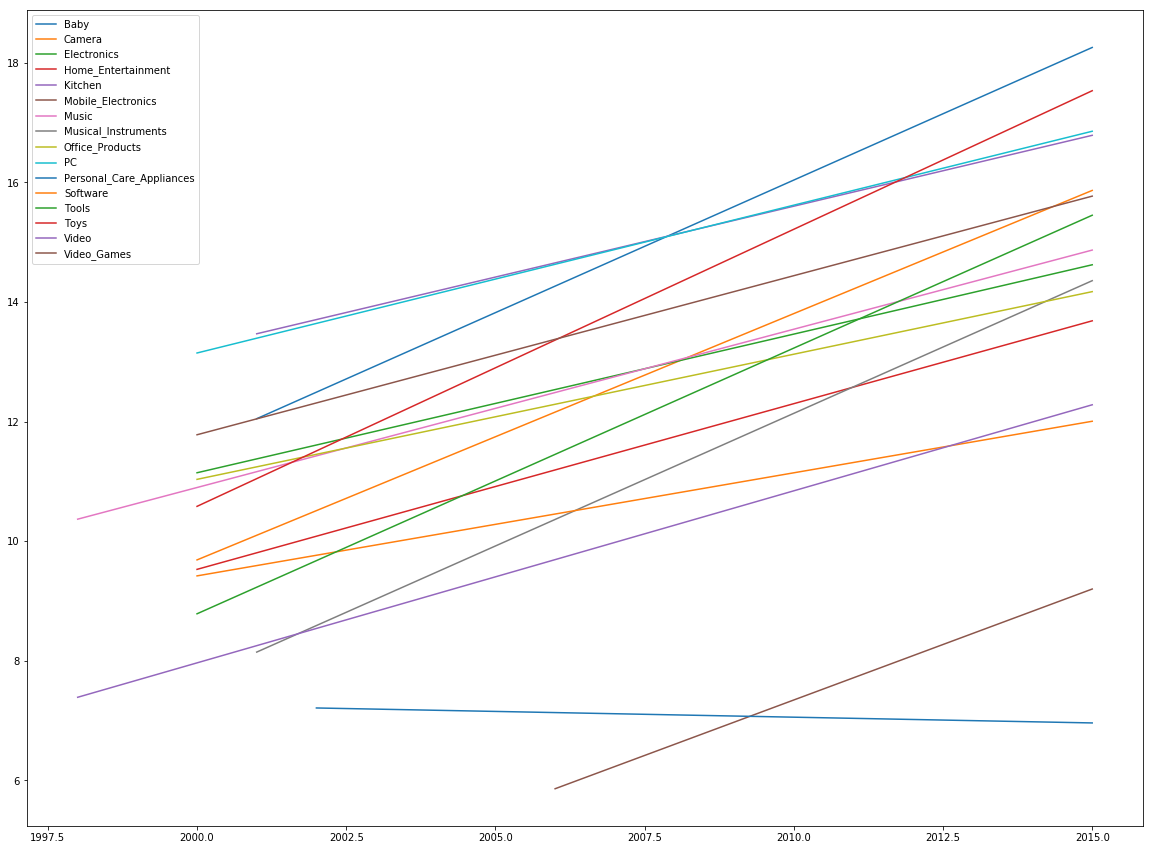

In [265]:
plt.figure(figsize=(20,15)) 

for name, group in df_overlaps_tfidf.groupby('category'):
    x = group['year_from_to'].dt.year
    y = group['overlap_pct']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    if z[0] < 0.5:
#     plt.plot(x,y, label=name)
        plt.plot(x,p(x), label=name)
    
plt.legend()
plt.show()


**Notes**: At this point we can reflect on the results of the TF-IDF analysis to determine whether the terms which are being identified are useful, and also whether the transfer of terms across the years provides any value with respects to the overall consistency of language used within the reviews. One way of thinking about the results is that the language overlap could be considered as a metric of homogenity within the review samples. The current approach does not normalize against new products being introduced throughout the years, so it may be that this analysis is contaminated due to this factor.

# YET TO BE WORKED ON

## Modelling

Here we're going to start to explore different modelling approaches to building our insights and predictive capability for this dataset.

There's a number of model's we're going to first try to develop a word embedding model which will help us develop the underlying structure of our reviews/words which can then be used as latent representations for our sentiment scores 

### Data Prep

Before we can use our data, we need to convert it from Parquet to RecordIO

In [ ]:
%%time

def read_parquet_file(filename):
    pf = ParquetFile(filename)
    return pf.to_pandas()

def convert_parquet_to_recordio(configs, manifest):
    dfs = []
     ##Create Augmented JSON Record file
    aug_train = []
    fs = s3fs.S3FileSystem()
    
    cnt = 0
    maxi = 1000000
    known_dates = {}
    tot_rows = 0
    for x in manifest:
        if cnt < maxi:
            date = x['date']
            if date not in known_dates:
                known_dates[date] = True
                absolute_path = 's3://{}/{}'.format(configs['bucket_name'], x['path_with_prefix'])
                folders = x['path_with_prefix'].split('/')
                path = ''
                for folder in folders:
                    if 'part' not in folder:
                        path = path + '/' + folder
                absolute_path = 's3://{}{}'.format(configs['bucket_name'], path)
                try:
                    dataset = pq.ParquetDataset(absolute_path,filesystem=fs)
                    table = dataset.read()
#                     df = table.to_pandas()
                    tot_rows += df.shape[0]
                    print('date {}. rows {}'.format(x['date'],df.shape[0]))
#                     dfs.append(df)
                    cnt += 1

                except:
                    print('could not load files in folder {}'.format(x['date']))
                
    print('Total Rows {}'.format(tot_rows))
    
    
#     train_file_s3 = 'train_lst/train_manifest.json'
#     s3_bucket.upload_file('./train_manifest.json', train_file_s3)

convert_parquet_to_recordio(configs, sampled_manifest)


In [ ]:
def upload_manifest(configs, manifest):
    
     ##Create Augmented JSON Record file
    aug_train = []
    
    for x in manifest:
        absolute_path = 's3://{}/{}'.format(configs['bucket_name'], x['path_with_prefix'])
        dic = {'source-ref':absolute_path}
        aug_train.append(dic)
        print(aug_train)
        break
    with open('train_manifest.json', 'w') as fout:
        for x in aug_train:
            fout.write(json.dumps(x)+'\n')
            #json.dump(aug_train, fout, indent=4)
    
        
    
#     train_file_s3 = 'train_lst/train_manifest.json'
#     s3_bucket.upload_file('./train_manifest.json', train_file_s3)

upload_manifest(configs, sampled_manifest)